In [7]:
import numpy as np
import matplotlib.pyplot as plt

def dphase(K,phase,freq,R,Theta):
    d_phase = freq-K*R*np.sin(phase-Theta)
    return d_phase 

def mean_field(freq): #calculates the mean field of a bunch of oscillators
    r_exp_iO = np.sum(np.exp(freq*1j))/N
    R = np.abs(r_exp_iO)
    Theta = np.angle(r_exp_iO)
    return R, Theta

def modified_euler(K,phase,freq,R,Theta,h): #Modified Euler algorithm to get new phase 
    phase_tilde = phase + h*dphase(K,phase,freq,R,Theta)
    phase_new = phase + 0.5*h*(dphase(K,phase,freq,R,Theta)+dphase(K,phase_tilde,freq,R,Theta))
    return phase_new

def evolution(K,phase,freq,T,h=0.1):
    phase_list = []
    R_list = []
    Theta_list = []
    for t in range(int(T/h)):
        R,Theta = mean_field(phase)
        phase = modified_euler(K,phase,freq,R,Theta,h)
        phase_list.append(phase)
        R_list.append(R)
        Theta_list.append(Theta)
    return np.linspace(0,T,int(T/h)),np.array(phase_list).transpose(),np.array(R_list).transpose(),np.array(Theta_list).transpose()

N = 1000
freq = np.random.normal(0,0.1,size=N) #oscillator freq
phase0 = np.random.normal(0,1,size=N) #starting phase of oscillator 
T = 20
K = 1
t,phase,R,Theta = evolution(K,phase0,freq,T)
phase = (phase+np.pi)%(2*np.pi)-np.pi
Theta = (Theta+np.pi)%(2*np.pi)-np.pi




Text(0.5, 1.0, 'N=1000')

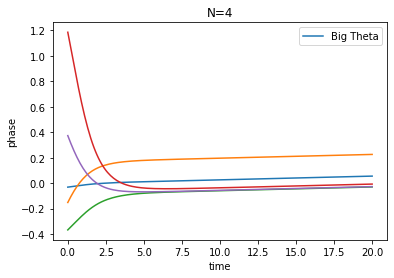

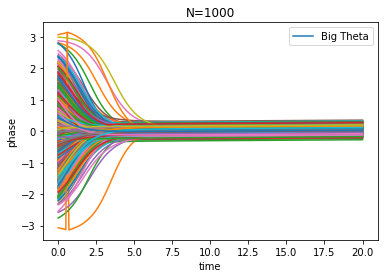

In [202]:
fig1,ax1 = plt.subplots(nrows=1,ncols=1)
ax1.plot(t,Theta,label="Big Theta")
for i in range(4):
    ax1.plot(t,phase[i])
ax1.set_xlabel("time")
ax1.set_ylabel("phase")
ax1.legend()
ax1.set_title("N=4")

fig2,ax2 = plt.subplots(nrows=1,ncols=1)
#ax.plot(t,R)
for i in range(1000):
    ax2.plot(t,phase[i])
ax2.plot(t,Theta,label="Big Theta")
ax2.set_xlabel("time")
ax2.set_ylabel("phase")
ax2.legend()
ax2.set_title("N=1000")



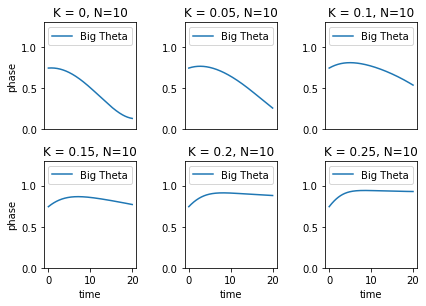

In [32]:
K = [[0,0.05,0.1],[0.15,0.2,0.25,0.3]]
N = 10
T = 20
freq = np.random.normal(0,0.1,size=N) #oscillator freq
phase0 = np.random.normal(0,1,size=N) #starting phase of oscillator 

fig2,ax2 = plt.subplots(nrows=2,ncols=3)
fig2.tight_layout()
for i in range(2):
    for j in range(3):
        t,phase,R,Theta = evolution(K[i][j],phase0,freq,T)
        ax2[i][j].plot(t,R,label="Big Theta")
        if i == 1:
            ax2[i][j].set_xlabel("time")
        elif i == 0:
            ax2[i][j].set_xticks([])
        if j == 0:
            ax2[i][j].set_ylabel("phase")
        ax2[i][j].legend(loc="upper center")
        ax2[i][j].set_title("K = {}, N={}".format(K[i][j],N))
        ax2[i][j].set_ylim([0,1.3])




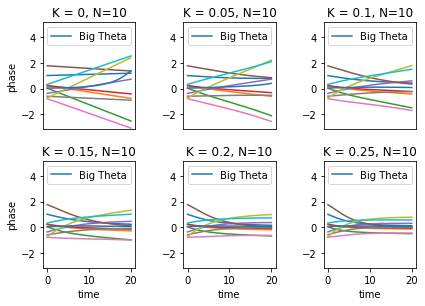

In [33]:

#phase plots 
fig1,ax1 = plt.subplots(nrows=2,ncols=3)
fig1.tight_layout()
for i in range(2):
    for j in range(3):
        t,phase,R,Theta = evolution(K[i][j],phase0,freq,T)
        phase = (phase+np.pi)%(2*np.pi)-np.pi
        Theta = (Theta+np.pi)%(2*np.pi)-np.pi
        for m in range(N):
            ax1[i][j].plot(t,phase[m])
        ax1[i][j].plot(t,Theta,label="Big Theta")
        if i == 1:
            ax1[i][j].set_xlabel("time")
        elif i == 0:
            ax1[i][j].set_xticks([])
        if j == 0:
            ax1[i][j].set_ylabel("phase")
        ax1[i][j].legend(loc="upper center")
        ax1[i][j].set_title("K = {}, N={}".format(K[i][j],N))
        ax1[i][j].set_ylim([-np.pi,np.pi+2])



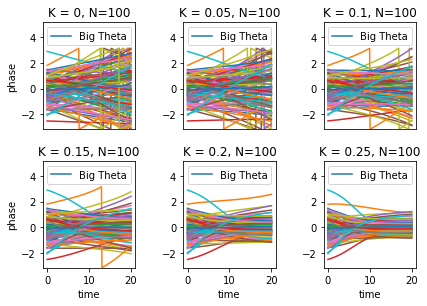

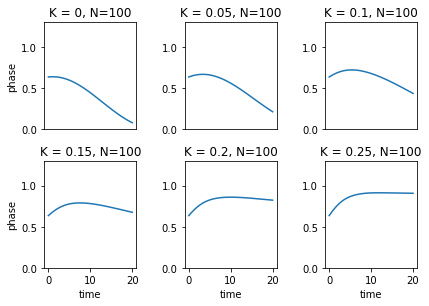

In [43]:

K = [[0,0.05,0.1],[0.15,0.2,0.25,0.3]]
N = 100
T = 20
freq = np.random.normal(0,0.1,size=N) #oscillator freq
phase0 = np.random.normal(0,1,size=N) #starting phase of oscillator 


#phase plots 
fig1,ax1 = plt.subplots(nrows=2,ncols=3)
fig2,ax2 = plt.subplots(nrows=2,ncols=3)
fig1.tight_layout()
fig2.tight_layout()
for i in range(2):
    for j in range(3):
        t,phase,R,Theta = evolution(K[i][j],phase0,freq,T)
        phase = (phase+np.pi)%(2*np.pi)-np.pi
        Theta = (Theta+np.pi)%(2*np.pi)-np.pi
        for m in range(N):
            ax1[i][j].plot(t,phase[m])
        ax1[i][j].plot(t,Theta,label="Big Theta")
        ax2[i][j].plot(t,R)
        if i == 1:
            ax1[i][j].set_xlabel("time")
            ax2[i][j].set_xlabel("time")
        elif i == 0:   
            ax1[i][j].set_xticks([])
            ax2[i][j].set_xticks([])
        if j == 0:
            ax1[i][j].set_ylabel("phase")
            ax2[i][j].set_ylabel("phase")
        ax1[i][j].legend(loc="upper center")
        ax1[i][j].set_title("K = {}, N={}".format(K[i][j],N))
        ax1[i][j].set_ylim([-np.pi,np.pi+2]) #to show the legend the right way 
        ax2[i][j].set_title("K = {}, N={}".format(K[i][j],N))
        ax2[i][j].set_ylim([0,1.3])
